# 0. Importar librerias y archivos necesarios

**Descargar unica vez**

In [ ]:
#!git clone https://github.com/pysentimiento/pysentimiento
#!python3 -m spacy download es_core_news_md

**Librerias neceasarias** (*Instalar unica vez*)

In [ ]:
!pip install tqdm pandas pandasql spacy transformers geopandas matplotlib seaborn xformers openpyxl
!pip install torch torchvision torchaudio
!pip install ipywidgets

In [1]:
import json
from collections import Counter

#Pandas
import pandas as pd
from pandasql import sqldf

#Spacy
import spacy
from spacy.matcher import PhraseMatcher
from spacy.matcher import Matcher
nlp = spacy.load("es_core_news_md")

#Pandas, Numpy, Matplotlib, Seaborn
import geopandas as gpd
import shapely as shp
import pandas
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors

# 1. Cargar variables desde archivo JSON

In [2]:
with open("datos.json", "r") as json_file:
    loaded_data = json.load(json_file)

COUNTRY = loaded_data["COUNTRY"]
REGION = loaded_data["REGION"]
NUMERO_REGION = loaded_data["NUMERO_REGION"]
COMUNAS = loaded_data["COMUNAS"]
MEDIA_OUTLETS = loaded_data["MEDIA_OUTLETS"]
KEYWORDS = loaded_data["KEYWORDS"]
START_DATE = loaded_data["START_DATE"]
END_DATE = loaded_data["END_DATE"]

# 2. Leer dataset de las noticias del territorio

In [3]:
FILE = "./noticias_los_rios_por_comuna_2022-01-01_2022-12-31.csv"

df_all = pd.read_csv(FILE)

df_topic = df_all[df_all['relevance_score'] != 0]

df_topic = df_topic.sort_values(by='relevance_score', ascending=False)

# 3. Cantidad de noticias por comuna: Figura 1

In [4]:
pysqldf = lambda q: sqldf(q, globals())

def generar_consulta(comunas_seleccionadas):
    selects_columnas = [f'sum("{comuna.replace(" ", "_")}") as "{comuna}"' for comuna in comunas_seleccionadas]
    selects_columnas_str = ",\n".join(selects_columnas)
    
    consulta = f"""
    SELECT
        {selects_columnas_str}
    FROM df_all
    """
    
    return consulta

consulta = generar_consulta(COMUNAS)

print("Cantidad de noticias total en 2022")

# Luego, puedes ejecutar la consulta con la función pysqldf
resultado_consulta_noticias = pysqldf(consulta)

resultado_consulta_noticias

Cantidad de noticias total en 2022


,Valdivia,Mariquina,Lanco,Panguipulli,La Unión,Río Bueno,Corral,Paillaco,Máfil,Futrono,Los Lagos,Lago Ranco
0,4296,363,350,654,824,630,305,973,221,960,952,404


In [5]:
def generar_consulta(comunas_seleccionadas):
    selects_columnas = [f'sum("{comuna.replace(" ", "_")}") as "{comuna}"' for comuna in comunas_seleccionadas]
    selects_columnas_str = ",\n".join(selects_columnas)
    
    consulta = f"""
    SELECT
        {selects_columnas_str}
    FROM df_topic
    """
    
    return consulta

consulta = generar_consulta(COMUNAS)

print("Cantidad de noticias en 2022 sobre el tópico")

# Luego, puedes ejecutar la consulta con la función pysqldf
resultado_consulta_topicos = pysqldf(consulta)

resultado_consulta_topicos

Cantidad de noticias en 2022 sobre el tópico


,Valdivia,Mariquina,Lanco,Panguipulli,La Unión,Río Bueno,Corral,Paillaco,Máfil,Futrono,Los Lagos,Lago Ranco
0,833,66,77,152,181,115,98,131,41,225,166,108


In [6]:
print("Tasa de noticias sobre el tópico")

ratio = resultado_consulta_topicos/resultado_consulta_noticias.values
ratio

Tasa de noticias sobre el tópico


,Valdivia,Mariquina,Lanco,Panguipulli,La Unión,Río Bueno,Corral,Paillaco,Máfil,Futrono,Los Lagos,Lago Ranco
0,0.193901,0.181818,0.22,0.232416,0.21966,0.18254,0.321311,0.134635,0.18552,0.234375,0.17437,0.267327


# 4. Métodos para la visualización de mapas

In [7]:
SHAPEFILE=r'./shape/comunas.shp' #shapefile de las regiones y comunas de Chile

# fuente: https://www.bcn.cl/siit/mapas_vectoriales

territory = gpd.read_file(SHAPEFILE, encoding='utf-8')
territory = territory[territory["codregion"] == NUMERO_REGION]
# Obtenemos los datos de las Columnas "Comuna", "geometry"
territory = territory[["Comuna", "geometry"]]

In [8]:
from matplotlib.patheffects import withStroke, Normal

def save_map(df, territory, image_name: str = "Mapa_Calor"):
    # Junta las tablas df y territory
    territory = territory.merge(df, on="Comuna")
    
    # Inicializa matplotlib para la creación del mapa
    fig, ax = plt.subplots(figsize=(10, 10))
    max_presente = df['Valor'].max()  # Valor máximo para la barra de calor
    territory.plot(column='Valor', ax=ax, edgecolor="gray", cmap='OrRd', legend=False).set_axis_off()
    
    # Agrega etiquetas de comunas en el mapa con sombra
    for i, row in territory.iterrows():
        comuna = row['Comuna']
        porcentaje = row['Valor']
        x = row['geometry'].centroid.x
        y = row['geometry'].centroid.y
        
        # Determinar el color de la etiqueta según el color del fondo
        fondo = row['Valor']
        
        # Usar un color de etiqueta más brillante en áreas de fondo oscuro
        etiqueta_color = 'white'  # Fondo oscuro, etiqueta clara
        
        # Agregar comuna y porcentaje en la etiqueta con sombra
        etiqueta_text = f'{comuna}\n{porcentaje:.2%}'  # Formatear el porcentaje como texto
        sombra = withStroke(linewidth=3, foreground="gray")  # Configurar la sombra
        ax.text(x, y, etiqueta_text, fontsize=10, ha='center', va='center', color=etiqueta_color, path_effects=[sombra, Normal()])
    
    bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=max_presente))
    bar_info._A = []
    cbar = fig.colorbar(bar_info)



# 5. Visualizar mapa de las comunas mostrando la tasa de noticias sobre el tópico: Figura 2

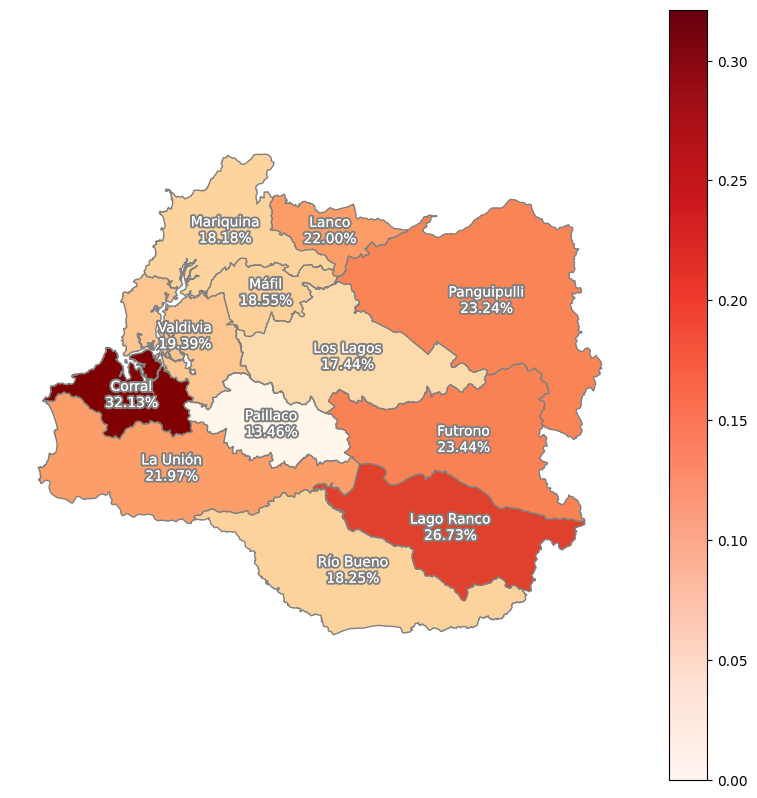

In [9]:
df=ratio

lista =[]
cont = 0
for i in territory["Comuna"]:
    lista.append({"Comuna": i, "Valor": ratio[i][0]})
    cont +=1
df = pandas.DataFrame(lista)

save_map(df, territory, "mapa")

# Guardar imagen en nombre_imagen con borde reducido
plt.savefig('mapa_calor.png', bbox_inches="tight", pad_inches=0, transparent=True)

# 6. Mostrar la relación entre la cantidad de habitantes y el número de noticias sobre el tópico: Figura 3

In [14]:
#--> Modificar los habitantes (por genero o general).

dataset_habitantes = pd.read_csv("./habitantes_por_comuna.csv")

# Convertir la lista de comunas a mayúsculas
comunas_mayusculas = [comuna.upper() for comuna in COMUNAS]

# Filtrar el DataFrame basado en la columna 'NOMBRE COMUNA'
filas_encontradas = dataset_habitantes[dataset_habitantes['NOMBRE COMUNA'].isin(comunas_mayusculas)]

# Imprimir las filas encontradas
#print(filas_encontradas)

# Crear un diccionario vacío para almacenar los resultados
comunas_totales = {}

# Iterar a través de las filas encontradas y agregar las comunas y totales al diccionario
for index, row in filas_encontradas.iterrows():
    comuna = row['NOMBRE COMUNA']
    total = int(row['TOTAL'].replace(',', ''))  # Convertir cadena a entero y eliminar comas
    comunas_totales[comuna] = total

# Imprimir el diccionario resultante
#print(comunas_totales)

resultados_grafico = []
for comuna in COMUNAS:
    noticias = resultado_consulta_topicos.loc[0, comuna]
    habitantes = comunas_totales[comuna.upper()]
    resultados_grafico.append({'Comuna': comuna, 'Noticias': noticias, 'Habitantes': habitantes})

# Crear un nuevo DataFrame con la información combinada
df = pd.DataFrame(resultados_grafico)

resultados = []
for comuna in COMUNAS:
    topicos = resultado_consulta_topicos.loc[0, comuna]
    noticias = resultado_consulta_noticias.loc[0, comuna]
    habitantes = comunas_totales[comuna.upper()]
    porcentajes = ratio.loc[0,comuna]
    porcentaje_formateado = '{:.2%}'.format(porcentajes)
    resultados.append({'Comunas': comuna, 'Cantidad de noticias sobre Turismo': topicos, 'Cantidad de noticias totales' : noticias, 'Número de Habitantes': habitantes, "Imporatancia de la cultura en la cobertura mediatica de la comuna": porcentaje_formateado})

# Crear un nuevo DataFrame con la información combinada
df_tabla = pd.DataFrame(resultados)

# Imprimir el DataFrame resultante
df_tabla

,Comunas,Cantidad de noticias sobre Turismo,Cantidad de noticias totales,Número de Habitantes,Imporatancia de la cultura en la cobertura mediatica de la comuna
0,Valdivia,833,4296,166080,19.39%
1,Mariquina,66,363,21278,18.18%
2,Lanco,77,350,16752,22.00%
3,Panguipulli,152,654,34539,23.24%
4,La Unión,181,824,38036,21.97%
5,Río Bueno,115,630,31372,18.25%
6,Corral,98,305,5302,32.13%
7,Paillaco,131,973,20188,13.46%
8,Máfil,41,221,7095,18.55%
9,Futrono,225,960,14665,23.44%


In [15]:
import pandas as pd

# Supongamos que ya tienes el DataFrame 'df' con tus datos

# Define el nombre del archivo Excel de salida
nombre_archivo_excel = 'informe_comunas.xlsx'

# Guarda el DataFrame como un archivo Excel
df_tabla.to_excel(nombre_archivo_excel, index=False)

# Confirma que el archivo se ha guardado exitosamente
print(f'El archivo Excel "{nombre_archivo_excel}" ha sido guardado.')

# También puedes guardar el DataFrame con un índice si lo deseas
# df.to_excel(nombre_archivo_excel)

El archivo Excel "informe_comunas.xlsx" ha sido guardado.


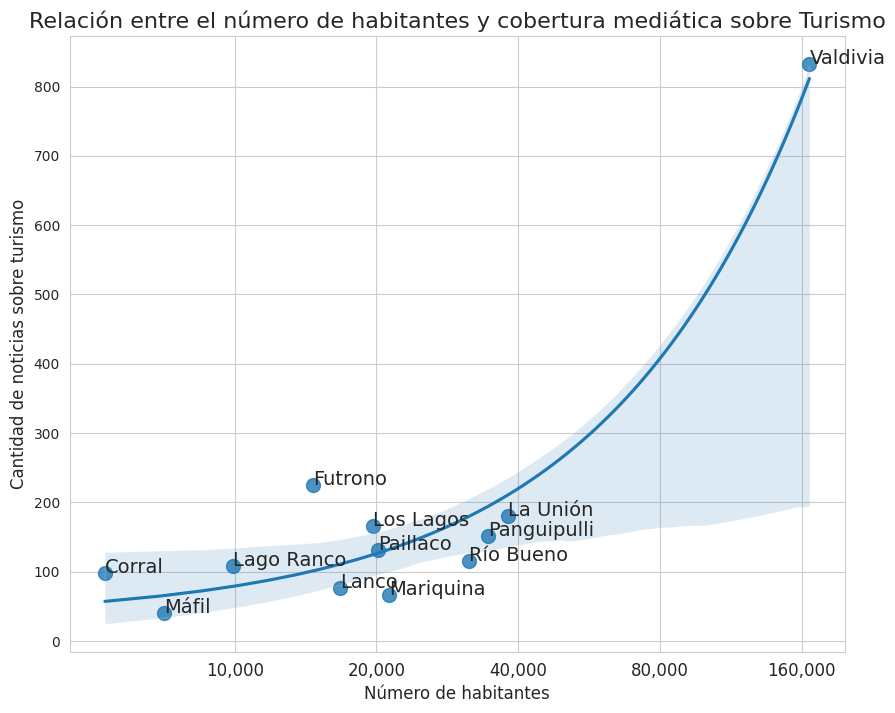

In [17]:
# Crear gráfico
sns.set_style('whitegrid') # Agregado para cambiar el estilo
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.regplot(x='Habitantes', y='Noticias', data=df, scatter_kws={"s": 100})

# Escala logarítmica en el eje X
ax.set_xscale('log')

# Formatear los ticks del eje X para que muestren los números de habitantes completos
def format_tick(x, pos):
    return '{:,.0f}'.format(x)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_tick))

# Configuración del eje X
ticks = [10000, 20000, 40000, 80000, 160000]
ax.set_xticks(ticks)
ax.set_xticklabels([f"{t:,}" for t in ticks], fontsize=12)

# Agregar nombres de comunas
for i in range(len(df)):
        ax.annotate(df.iloc[i]['Comuna'], (df.iloc[i]['Habitantes'], df.iloc[i]['Noticias']), fontsize=14)

# Añadir título y etiquetas de los ejes
ax.set_title('Relación entre el número de habitantes y cobertura mediática sobre Turismo', fontsize=16)
ax.set_xlabel('Número de habitantes', fontsize=12)
ax.set_ylabel('Cantidad de noticias sobre turismo', fontsize=12)

plt.savefig('mapa_de_relacion.png', bbox_inches="tight", pad_inches=0, transparent=True)
plt.show()


# 7. Mostrar cómo evoluciona el ratio 'noticias sobre el tópico' y 'noticias totales' de cada comuna, a lo largo de los meses: Figura 4

In [18]:
#Calcular la cantidad total de noticias por mes por cada comuna

# Reemplazar espacios por guiones bajos en los nombres de las comunas
comuna_seleccionada = [comuna.replace(" ", "_") for comuna in COMUNAS]

# Filtrar el dataset original para las comunas seleccionadas
dataset_cities_copy = df_all.loc[:, ['date'] + comuna_seleccionada]

dataset_cities_copy['date'] = pd.to_datetime(dataset_cities_copy['date'])
dataset_cities_copy = dataset_cities_copy.groupby(pd.Grouper(key='date', freq='M')).sum()

In [19]:
#Calcular la cantidad total de noticias del topico por mes por cada comuna

dataset_cities_topic_copy = df_topic.loc[:, ["date"] + comuna_seleccionada]

dataset_cities_topic_copy['date'] = pd.to_datetime(dataset_cities_topic_copy['date'])
dataset_cities_topic_copy = dataset_cities_topic_copy.groupby(pd.Grouper(key='date', freq='M')).sum()

In [20]:
ratio_per_month = dataset_cities_topic_copy / dataset_cities_copy.values
ratio_per_month

,Valdivia,Mariquina,Lanco,Panguipulli,La_Unión,Río_Bueno,Corral,Paillaco,Máfil,Futrono,Los_Lagos,Lago_Ranco
date,,,,,,,,,,,,
2022-01-31,0.240000,0.346154,0.241379,0.346154,0.222222,0.139535,0.347826,0.219178,0.176471,0.319444,0.160920,0.162162
2022-02-28,0.186885,0.206897,0.238095,0.208955,0.169231,0.156250,0.448276,0.085714,0.153846,0.226667,0.164557,0.290323
2022-03-31,0.171196,0.135135,0.131579,0.268293,0.148148,0.153846,0.200000,0.125000,0.200000,0.189873,0.114286,0.190476
2022-04-30,0.200000,0.108108,0.157895,0.367647,0.322222,0.183673,0.333333,0.131148,0.185185,0.327103,0.252427,0.529412
2022-05-31,0.197292,0.250000,0.346154,0.218182,0.220930,0.250000,0.600000,0.133929,0.166667,0.344086,0.211009,0.370370
2022-06-30,0.184539,0.181818,0.210526,0.157895,0.189873,0.180328,0.243902,0.123288,0.111111,0.220339,0.160494,0.200000
2022-07-31,0.203252,0.086957,0.305556,0.212121,0.188679,0.183673,0.250000,0.234375,0.131579,0.225000,0.158730,0.148148
2022-08-31,0.210243,0.088235,0.242424,0.253968,0.196970,0.217391,0.320000,0.130952,0.240000,0.190476,0.260870,0.322581
2022-09-30,0.182390,0.193548,0.235294,0.163265,0.191489,0.103448,0.233333,0.059524,0.263158,0.083333,0.113402,0.152174


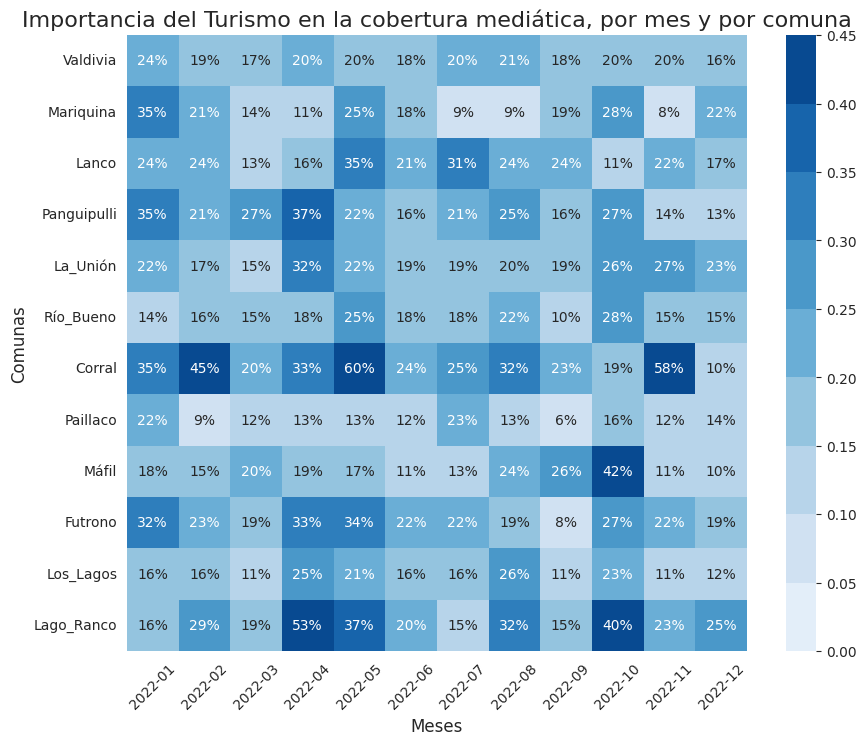

In [24]:
# Crear paleta de colores con 5 tonos de azul
cmap = ListedColormap(sns.color_palette("Blues", n_colors=9, desat=1).as_hex())

# Crear gráfico
sns.set_style('whitegrid') # Agregado para cambiar el estilo
fig, ax = plt.subplots(figsize=(10, 8))

# Crear heatmap con escala limitada a 0-0.5 y la nueva paleta de colores
sns.heatmap(ratio_per_month.T, cmap=cmap, annot=True, fmt='.0%', ax=ax, vmin=0.0, vmax=0.45)

# Formatear etiquetas del eje X para mostrar solo el año y el mes
labels = [d.strftime('%Y-%m') for d in ratio_per_month.index]
ax.set_xticklabels(labels, rotation=45)

# Añadir título y etiquetas de los ejes
ax.set_title('Importancia del Turismo en la cobertura mediática, por mes y por comuna', fontsize=16)
ax.set_xlabel('Meses', fontsize=12)
ax.set_ylabel('Comunas', fontsize=12)

plt.savefig('mapa_calor_cuadrado.png', bbox_inches="tight", pad_inches=0, transparent=False)
plt.show()

# 8. Visualizar el análisis de sentimiento por comuna (todas las noticias): Figura 5

In [46]:
# Lista de comunas
comunas = comuna_seleccionada

# Crear un diccionario para almacenar los resultados
resultados_dict = {"comuna": [], "POS": [], "NEU": [], "NEG": []}

# Calcular el número de predicciones POS, NEU, NEG para cada comuna
for comuna in comunas:
    pos_count = 0
    neu_count = 0
    neg_count = 0
    for i, valor in enumerate(df_all[comuna]):
        if valor == 1:
            if df_all["prediction"][i] == "POS":
                pos_count += 1
            elif df_all["prediction"][i] == "NEU":
                neu_count += 1
            elif df_all["prediction"][i] == "NEG":
                neg_count += 1
    resultados_dict["comuna"].append(comuna)
    resultados_dict["POS"].append(pos_count)
    resultados_dict["NEU"].append(neu_count)
    resultados_dict["NEG"].append(neg_count)

# Crear el DataFrame a partir del diccionario de resultados
resultados = pd.DataFrame(resultados_dict)

resultados

,comuna,POS,NEU,NEG
0,Valdivia,282,2951,1063
1,Mariquina,38,228,97
2,Lanco,27,256,67
3,Panguipulli,45,457,152
4,La_Unión,79,587,158
5,Río_Bueno,70,424,136
6,Corral,28,221,56
7,Paillaco,66,675,232
8,Máfil,17,155,49
9,Futrono,79,661,220


In [47]:
resultados['sentimientos'] = (resultados['POS'] + 0.5*resultados['NEU']) / (resultados['POS'] + resultados['NEG'] + resultados['NEU'])

resultados['comuna'] = resultados['comuna'].str.replace('_', ' ')

resultados

,comuna,POS,NEU,NEG,sentimientos
0,Valdivia,282,2951,1063,0.409101
1,Mariquina,38,228,97,0.418733
2,Lanco,27,256,67,0.442857
3,Panguipulli,45,457,152,0.418196
4,La Unión,79,587,158,0.452063
5,Río Bueno,70,424,136,0.447619
6,Corral,28,221,56,0.454098
7,Paillaco,66,675,232,0.414697
8,Máfil,17,155,49,0.427602
9,Futrono,79,661,220,0.426563


In [48]:
# Unir los datos de resultados con el shapefile
comunas_resultados = territory.merge(resultados, left_on='Comuna', right_on='comuna')

# Redondear el puntaje de sentimientos a 3 decimales
comunas_resultados['sentimientos'] = comunas_resultados['sentimientos'].apply(lambda x: round(x, 3))

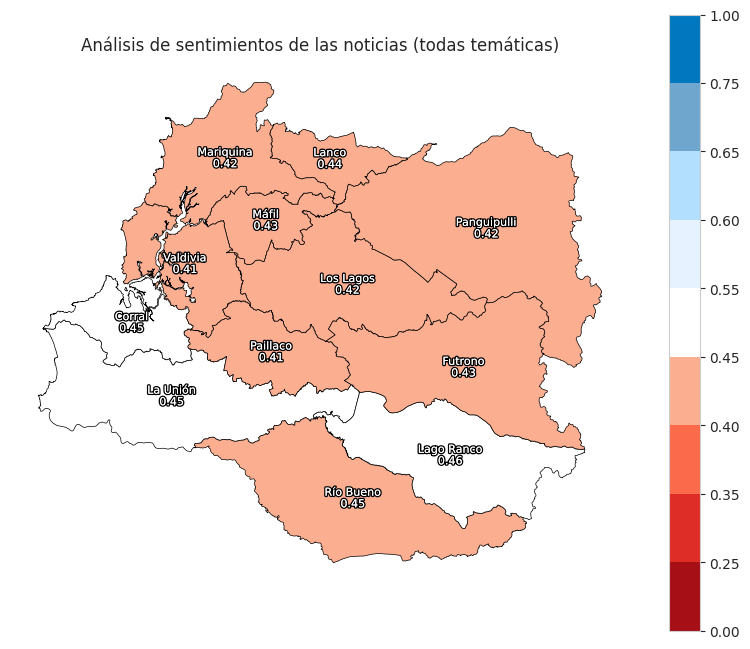

In [49]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.patheffects import withStroke, Normal
from matplotlib import colors

limits = [0, 0.25, 0.35, 0.4, 0.45, 0.55, 0.6, 0.65, 0.75, 1]
colors_list = ['#A50F15', '#DE2D26', '#FB6A4A', '#FCAE91', '#FFFFFF', '#e6f2ff', '#b3dfff', '#6ea6cd', '#0077be']

# Crear el mapa
fig, ax = plt.subplots(figsize=(10, 8))

# Crear la escala de color personalizada
cmap = colors.ListedColormap(colors_list)
norm = colors.BoundaryNorm(limits, cmap.N)

# Graficar las comunas en el mapa
comunas_resultados.plot(column='sentimientos', cmap=cmap, norm=norm, linewidth=0.5, edgecolor='black', legend=True, ax=ax)
ax.set_title('Análisis de sentimientos de las noticias (todas temáticas)')
ax.set_axis_off()

# Agregar comuna y puntaje de sentimiento en el centro de cada polígono con sombra
for idx, row in comunas_resultados.iterrows():
    centroid = row['geometry'].centroid
    sentimiento = row['sentimientos']
    x = centroid.x
    y = centroid.y
    
    # Determinar el color de la etiqueta según el color del fondo
    fondo = row['sentimientos']
    
    # Usar un color de etiqueta más brillante en áreas de fondo oscuro
    etiqueta_color = 'white' if fondo > 0.5 else 'white'
    
    # Agregar comuna y puntaje de sentimiento en la etiqueta con sombra
    etiqueta_text = f'{row["Comuna"]}\n{sentimiento:.2f}'  # Nombre de la comuna y puntaje de sentimiento
    sombra = withStroke(linewidth=2, foreground="black")  # Configurar la sombra
    ax.text(x, y, etiqueta_text, fontsize=8, ha='center', va='center', color=etiqueta_color, path_effects=[sombra, Normal()])

# Crear la barra de color (colorbar)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

plt.savefig('mapa_calor_sentimiento_topico.png', bbox_inches="tight", pad_inches=0, transparent=True)
plt.show()


# 9. Visualizar el análisis de sentimiento por comuna en las noticias sobre turismo: Figura 6

In [50]:
# Lista de comunas
comunas = comuna_seleccionada

# Crear un diccionario para almacenar los resultados
resultados_dict = {"comuna": [], "POS": [], "NEU": [], "NEG": []}

# Calcular el número de predicciones POS, NEU, NEG para cada comuna
for comuna in comunas:
    pos_count = 0
    neu_count = 0
    neg_count = 0
    for i, valor in enumerate(df_topic[comuna]):
        if valor == 1:
            if df_topic["prediction"][i] == "POS":
                pos_count += 1
            elif df_topic["prediction"][i] == "NEU":
                neu_count += 1
            elif df_topic["prediction"][i] == "NEG":
                neg_count += 1
    resultados_dict["comuna"].append(comuna)
    resultados_dict["POS"].append(pos_count)
    resultados_dict["NEU"].append(neu_count)
    resultados_dict["NEG"].append(neg_count)

# Crear el DataFrame a partir del diccionario de resultados
resultados = pd.DataFrame(resultados_dict)

resultados

,comuna,POS,NEU,NEG
0,Valdivia,127,595,111
1,Mariquina,9,50,7
2,Lanco,12,54,11
3,Panguipulli,28,97,27
4,La_Unión,31,131,19
5,Río_Bueno,17,78,20
6,Corral,9,82,7
7,Paillaco,20,83,28
8,Máfil,7,26,8
9,Futrono,36,152,37


In [51]:
resultados['sentimientos'] = (resultados['POS'] + 0.5*resultados['NEU']) / (resultados['POS'] + resultados['NEG'] + resultados['NEU'])
resultados['comuna'] = resultados['comuna'].str.replace('_', ' ')

In [52]:
# Unir los datos de resultados con el shapefile
comunas_resultados = territory.merge(resultados, left_on='Comuna', right_on='comuna')

# Redondear el puntaje de sentimientos a 3 decimales
comunas_resultados['sentimientos'] = comunas_resultados['sentimientos'].apply(lambda x: round(x, 3))

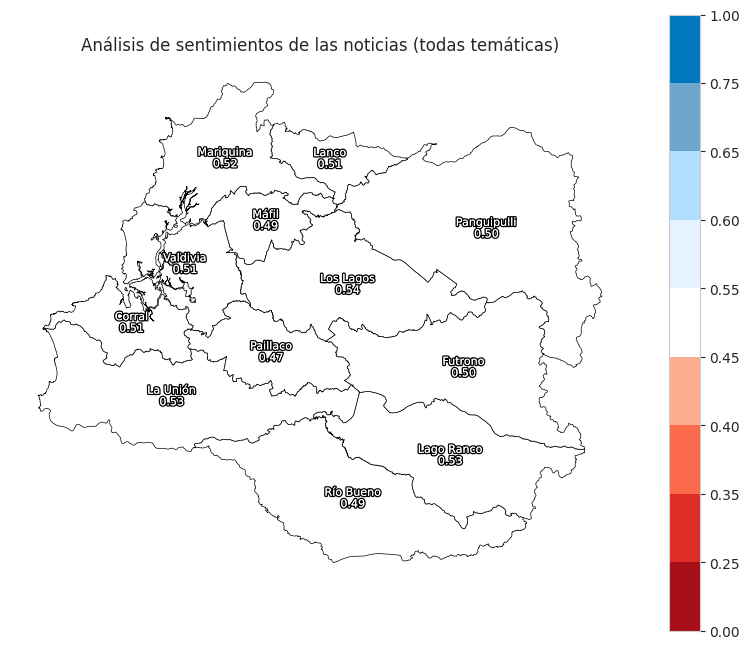

In [53]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.patheffects import withStroke, Normal
from matplotlib import colors

limits = [0, 0.25, 0.35, 0.4, 0.45, 0.55, 0.6, 0.65, 0.75, 1]
colors_list = ['#A50F15', '#DE2D26', '#FB6A4A', '#FCAE91', '#FFFFFF', '#e6f2ff', '#b3dfff', '#6ea6cd', '#0077be']

# Crear el mapa
fig, ax = plt.subplots(figsize=(10, 8))

# Crear la escala de color personalizada
cmap = colors.ListedColormap(colors_list)
norm = colors.BoundaryNorm(limits, cmap.N)

# Graficar las comunas en el mapa
comunas_resultados.plot(column='sentimientos', cmap=cmap, norm=norm, linewidth=0.5, edgecolor='black', legend=True, ax=ax)
ax.set_title('Análisis de sentimientos de las noticias (todas temáticas)')
ax.set_axis_off()

# Agregar comuna y puntaje de sentimiento en el centro de cada polígono con sombra
for idx, row in comunas_resultados.iterrows():
    centroid = row['geometry'].centroid
    sentimiento = row['sentimientos']
    x = centroid.x
    y = centroid.y
    
    # Determinar el color de la etiqueta según el color del fondo
    fondo = row['sentimientos']
    
    # Usar un color de etiqueta más brillante en áreas de fondo oscuro
    etiqueta_color = 'white' if fondo > 0.5 else 'white'
    
    # Agregar comuna y puntaje de sentimiento en la etiqueta con sombra
    etiqueta_text = f'{row["Comuna"]}\n{sentimiento:.2f}'  # Nombre de la comuna y puntaje de sentimiento
    sombra = withStroke(linewidth=2, foreground="black")  # Configurar la sombra
    ax.text(x, y, etiqueta_text, fontsize=8, ha='center', va='center', color=etiqueta_color, path_effects=[sombra, Normal()])

# Crear la barra de color (colorbar)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

plt.savefig('mapa_calor_sentimiento_total.png', bbox_inches="tight", pad_inches=0, transparent=True)
plt.show()


# 10. Visualizar la evolución de la cantidad y polaridad de las noticias de turismo de comuna especifica: Figura 7

In [57]:
from ipywidgets import Dropdown, VBox, Output

# Lista de opciones para el segundo Dropdown
opciones_lista = ['Valdivia', 'Mariquina', 'Lanco', 'Panguipulli', 'La Unión', 'Río Bueno', 'Corral', 'Paillaco', 'Máfil', 'Futrono', 'Los Lagos', 'Lago Ranco']

# Crear los Dropdowns
dropdown_lista = Dropdown(options=opciones_lista, description='Opciones de Lista')

# Crear los Outputs
output_seleccion = Output()

# Variable para almacenar la opción seleccionada
opcion_seleccionada = ""

# Función para mostrar la selección del segundo Dropdown
def mostrar_seleccion(change):
    global opcion_seleccionada  # Indicar que la variable es del ámbito exterior
    opcion_seleccionada = change['new']

    with output_seleccion:
        output_seleccion.clear_output()
        print("Comuna seleccionada de", str(REGION).title().replace("_", " "), ": ", opcion_seleccionada)

# Enlazar los eventos de cambio de selección a las funciones correspondientes
dropdown_lista.observe(mostrar_seleccion, names='value')

# Mostrar los Dropdowns y los Outputs
VBox([dropdown_lista, output_seleccion])

In [61]:
dataset_turism = df_topic[df_topic[opcion_seleccionada] == 1]


In [62]:
dataset_turism

,id_news,country,media_outlet,url,title,text,date,Lago_Ranco,Los_Lagos,Futrono,...,Río_Bueno,La_Unión,Panguipulli,Lanco,Mariquina,Valdivia,found_keywords,relevance_score,prediction,score
0,47782013.0,chile,diariodevaldivia,https://www.diariodevaldivia.cl/noticia/report...,Restricción vehicular: ¿la solución contra la ...,Por Roberto Cadagán Lunes 26 de septiembre y u...,2022-10-02,0,0,0,...,0,0,0,0,0,1,"['parque', 'transporte', 'transporte', 'transp...",26,NEU,0.973930
1,47768513.0,chile,diariodevaldivia,https://www.diariodevaldivia.cl/noticia/panora...,Evento Valdivia Patrimonial prepara programa d...,Del 17 al 20 de noviembre se efectuará el even...,2022-11-10,0,0,0,...,0,0,0,0,0,1,"['patrimonio', 'patrimonio', 'patrimonio', 'fe...",24,NEU,0.989068
2,47773169.0,chile,diariodevaldivia,https://www.diariodevaldivia.cl/noticia/panora...,Valdivia tendrá un inédito evento patrimonial ...,Un encuentro con la historia de Valdivia está ...,2022-10-20,0,0,0,...,0,0,0,0,0,1,"['patrimonio', 'feria', 'patrimonio', 'patrimo...",18,NEU,0.941157
3,47681207.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/actualida...,Preocupante aumento registró parque vehicular ...,Durante el 2021 la Región de Los Ríos totalizó...,2022-08-27,1,1,1,...,1,1,1,1,1,1,"['transporte', 'transporte', 'parque', 'parque...",16,NEG,0.998533
4,47744623.0,chile,diariofutrono,https://www.diariofutrono.cl/noticia/turismo/2...,Valdivia es sede del IX Congreso Latinoamerica...,"Con el lema “Construyendo turismo responsable,...",2022-11-11,0,0,0,...,0,0,1,0,0,1,"['turismo', 'turismo', 'turismo', 'turismo', '...",16,NEU,0.946156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,47731007.0,chile,diarioriobueno,https://www.diarioriobueno.cl/noticia/deportes...,Gol y Gol de Río Bueno se coronó campeón regio...,Este sábado el equipo Gol y Gol de Río Bueno s...,2022-06-04,0,0,0,...,1,0,0,0,0,1,['visitantes'],1,POS,0.980552
981,47682553.0,chile,diariodevaldivia,https://www.diariodevaldivia.cl/noticia/salud/...,Conoce los puntos de testeos y vacunación para...,"Los supermercados Eltit, Líder, la Plaza de la...",2022-07-12,0,0,0,...,0,0,0,0,0,1,['hotel'],1,NEU,0.998306
982,47681684.0,chile,diariodevaldivia,https://www.diariodevaldivia.cl/noticia/politi...,Subsecretario del interior llegará a Los Ríos ...,"Este miércoles, el subsecretario del Interior ...",2022-07-20,0,1,0,...,1,1,1,1,0,1,['transporte'],1,NEU,0.959600
986,47731579.0,chile,diarioriobueno,https://www.diarioriobueno.cl/noticia/deportes...,Listas las llaves de semifinales del Regional ...,Un finalista de la provincia de Valdivia y otr...,2022-05-11,0,1,1,...,1,0,0,0,0,1,['parque'],1,NEU,0.982868


In [63]:
# convertir columna "date" a datetime si no lo está
dataset_turism['date'] = pd.to_datetime(dataset_turism['date'])

dataset_turism['year']=dataset_turism['date'].dt.year
dataset_turism['month']=dataset_turism['date'].dt.month

/tmp/ipykernel_3070/970704515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_turism['date'] = pd.to_datetime(dataset_turism['date'])
/tmp/ipykernel_3070/970704515.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_turism['year']=dataset_turism['date'].dt.year
/tmp/ipykernel_3070/970704515.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [64]:
dataset_turism = dataset_turism.groupby([dataset_turism['year'], dataset_turism['month'], 'prediction']).size().reset_index(name='count')

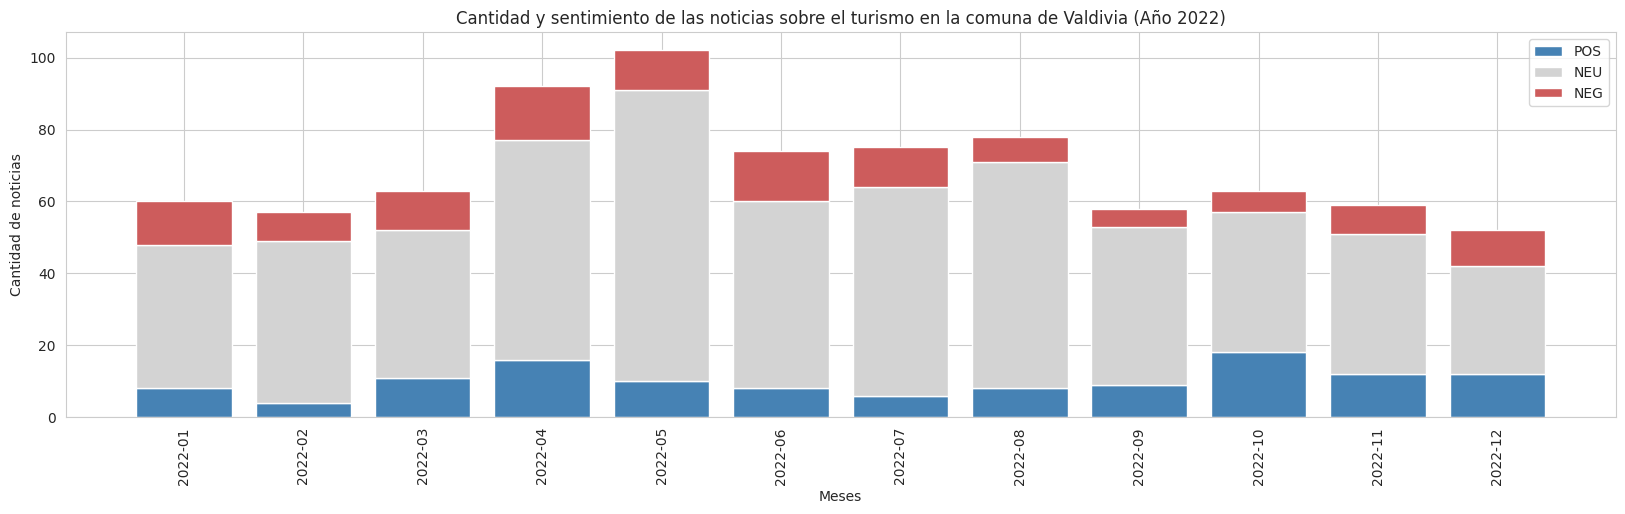

In [68]:
# crear una columna "date" a partir de "year" y "month"
dataset_turism["date"] = pd.to_datetime(dataset_turism["year"].astype(str) + "-" + dataset_turism["month"].astype(str) + "-01")

# utilizar pivot_table para contar los datos por mes y predicción
df_pivot = dataset_turism.pivot_table(index="date", columns="prediction", values="count", aggfunc=sum)

# crear una figura y un eje
fig, ax = plt.subplots()

# definir los colores para cada predicción
colors = {"POS": "steelblue", "NEU": "lightgray", "NEG": "indianred"}

# graficar las barras apiladas
x = df_pivot.index.strftime("%Y-%m")
bottom = np.zeros(len(df_pivot))
for prediction in ["POS", "NEU", "NEG"]:
    y = df_pivot[prediction].fillna(0).values
    ax.bar(x, y, bottom=bottom, color=colors[prediction],edgecolor='white', label=prediction)
    bottom += y

plt.xticks(rotation=90)
    
# ajustar el tamaño del gráfico
fig.set_size_inches(20, 5)

# agregar etiquetas y leyendas
ax.set_title("Cantidad y sentimiento de las noticias sobre el turismo en la comuna de " + opcion_seleccionada + " (Año 2022)")
ax.set_xlabel("Meses")
ax.set_ylabel("Cantidad de noticias")
ax.legend()

plt.savefig('S3_polaridad_Turismo.png')
# mostrar el gráfico
plt.show()

# 11. Cantidad de noticias por medios de prensa: Figura 9

In [69]:
dataset_turism = df_topic[df_topic[opcion_seleccionada] == 1]


In [70]:
# consultar el número de filas por cada media_outlet
query = '''
    SELECT media_outlet, COUNT(*) AS numero_noticias
    FROM dataset_turism
    GROUP BY media_outlet
    ORDER BY numero_noticias DESC
'''

df_count_by_media_outlet = sqldf(query)

df_count_by_media_outlet

,media_outlet,numero_noticias
0,diariodevaldivia,468
1,diariolaguino,247
2,elnaveghable,44
3,diarioriobueno,14
4,diariolaunion,13
5,diariopaillaco,12
6,diariofutrono,12
7,diariolanco,7
8,diariolagoranco,5
9,diariocorral,5


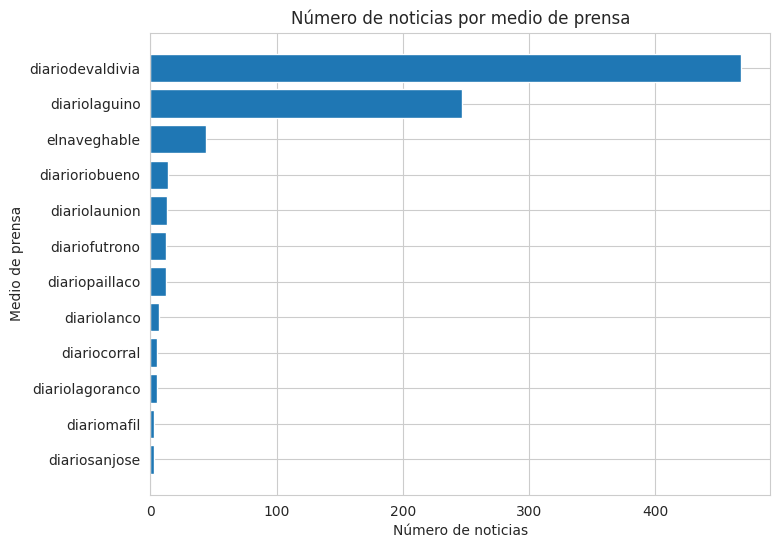

In [72]:
# ordenar el DataFrame por la columna 'count' de manera descendente
df_count_by_media_outlet_sorted = df_count_by_media_outlet.sort_values('numero_noticias', ascending=True)

# crear una figura y un eje con tamaño personalizado
fig, ax = plt.subplots(figsize=(8, 6))


# crear el gráfico de barras
ax.barh(df_count_by_media_outlet_sorted['media_outlet'], df_count_by_media_outlet_sorted['numero_noticias'])

# agregar etiquetas y títulos
ax.set_xlabel('Número de noticias')
ax.set_ylabel('Medio de prensa')
ax.set_title('Número de noticias por medio de prensa')

# mostrar el gráfico
plt.savefig('grafico_noticias_por_medio_prensa.png', bbox_inches="tight", pad_inches=0, transparent=True)

plt.show()

# 12. Extracción de las palabras claves: Figura 8

In [73]:
matcher = Matcher(nlp.vocab)
# pattern: NOUN-de-NOUN
pattern_1 = [{"POS": "NOUN"},{"LOWER": "de"}, {"POS": "NOUN"}]
matcher.add("NOUN-de-NOUN", [pattern_1])

# pattern: NOUN-ADJ
pattern_2 = [{"POS": "NOUN"}, {"POS": "ADJ"}]
matcher.add("NOUN-ADJ", [pattern_2])

# pattern: NOUN
pattern_3 = [{"POS": "NOUN"}]
matcher.add("NOUN", [pattern_3])

In [74]:
# Agregar columna "text_summary" con valor predeterminado en blanco
dataset_turism['text_summary'] = ''

/tmp/ipykernel_3070/161704348.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_turism['text_summary'] = ''


In [88]:
for index,row in dataset_turism.iterrows():
    print(index)
    title = row["title"]
    text = row["text"]
    
    text_summary=[]
    
    try:
        doc = nlp(title+". "+text)
        matches = matcher(doc)

        for match_id, start, end in matches:
            span = doc[start:end]  # The matched span
            text_summary.append(span.text)
    
        
    except:
        pass
    
    # Actualizar el valor de la columna "text_summary" en la fila actual
    dataset_turism.at[index, 'text_summary'] = text_summary

0
1
2
3
4
5
9
8
11
14
16
23
20
19
25
26
32
42
41
38
36
35
34
60
59
58
56
55
53
48
46
45
43
85
80
77
86
90
91
89
68
67
73
74
75
71
128
118
120
123
124
125
126
119
135
129
130
116
137
138
127
115
114
95
99
104
105
110
106
197
189
196
190
187
186
184
181
211
179
217
207
204
158
156
150
143
141
140
139
177
157
168
174
167
166
176
308
309
310
312
313
306
314
315
321
317
318
319
316
298
295
291
293
296
304
299
301
302
303
351
345
346
347
342
353
356
325
332
326
328
331
334
335
336
337
338
289
287
236
237
238
240
241
243
244
245
247
248
249
235
251
223
286
218
220
221
227
250
234
252
271
272
274
275
279
281
284
270
254
268
257
258
260
261
267
565
566
570
557
562
561
572
571
588
573
590
553
589
586
585
584
582
581
580
577
575
554
552
523
530
529
525
532
592
518
531
551
543
550
549
546
542
534
540
539
591
626
593
643
648
647
646
645
642
641
636
635
651
652
654
668
665
664
663
662
660
659
657
656
594
603
610
608
601
600
599
597
596
613
614
628
625
624
623
622
621
620
618
617
616
615
567
512
412


In [89]:
# Crear una lista de todas las palabras clave
all_keywords = []
for keywords in dataset_turism['text_summary']:
    all_keywords.extend(keywords)

# Contar la frecuencia de cada palabra y ordenar la lista
word_counts = Counter(all_keywords)

# Crear diccionarios para guardar las frecuencias de cada palabra en cada categoría
pos_word_counts = {}
neu_word_counts = {}
neg_word_counts = {}

# Contar la frecuencia de cada palabra en cada categoría
for index, row in dataset_turism.iterrows():
    for keyword in row['text_summary']:
        if row['prediction'] == 'POS':
            pos_word_counts[keyword] = pos_word_counts.get(keyword, 0) + 1
        elif row['prediction'] == 'NEU':
            neu_word_counts[keyword] = neu_word_counts.get(keyword, 0) + 1
        else:
            neg_word_counts[keyword] = neg_word_counts.get(keyword, 0) + 1

# Combinar las frecuencias de cada palabra en un solo dataframe
count_keywords_dataframe = pd.DataFrame(word_counts.items(), columns=['palabra', 'frecuencia'])
count_keywords_dataframe['frecuencia_POS'] = count_keywords_dataframe['palabra'].map(pos_word_counts)
count_keywords_dataframe['frecuencia_NEU'] = count_keywords_dataframe['palabra'].map(neu_word_counts)
count_keywords_dataframe['frecuencia_NEG'] = count_keywords_dataframe['palabra'].map(neg_word_counts)

# Ordenar el dataframe por la frecuencia total de cada palabra
count_keywords_dataframe = count_keywords_dataframe.sort_values(by='frecuencia', ascending=False)

count_keywords_dataframe


,palabra,frecuencia,frecuencia_POS,frecuencia_NEU,frecuencia_NEG
449,años,647,174.0,396.0,77.0
377,horas,594,139.0,416.0,39.0
55,personas,510,74.0,374.0,62.0
89,parte,502,81.0,369.0,52.0
296,región,447,70.0,341.0,36.0
...,...,...,...,...,...
10128,trabajo continuo,1,NaN,1.0,NaN
10129,convenio de cooperación,1,NaN,1.0,NaN
10130,labores de asistencia,1,NaN,1.0,NaN
10132,trabajo de exposiciones,1,NaN,1.0,NaN


In [90]:
pd.set_option('display.max_rows', 500)

count_keywords_dataframe[0:5000]

,palabra,frecuencia,frecuencia_POS,frecuencia_NEU,frecuencia_NEG
449,años,647,174.0,396.0,77.0
377,horas,594,139.0,416.0,39.0
55,personas,510,74.0,374.0,62.0
89,parte,502,81.0,369.0,52.0
296,región,447,70.0,341.0,36.0
...,...,...,...,...,...
7952,grueso,2,1.0,1.0,NaN
6920,represalias,2,NaN,NaN,2.0
12705,propietaria,2,NaN,2.0,NaN
6915,plaza de armas,2,1.0,1.0,NaN


# 13. Extraer ejemplos de noticias POS, NEG y NEU por cada mes de 2022: Figura 10

In [91]:
dataset_turism = dataset_turism.drop('text_summary', axis=1)

In [92]:
query = """
SELECT date, title, url, prediction, score
FROM dataset_turism
WHERE prediction = 'NEU'
ORDER BY score DESC
"""

result7 = pysqldf(query)
result7

,date,title,url,prediction,score
0,2022-06-05,Altos del Lago Ranco ofrece loteos ¿dentro de ...,https://www.diariolagoranco.cl/noticia/reporta...,NEU,0.998776
1,2022-05-04,Locomoción colectiva deberá pagar su permiso d...,https://www.diariodevaldivia.cl/noticia/actual...,NEU,0.998704
2,2022-08-03,Conoce el plazo de pago de la segunda cuota de...,https://www.diariodevaldivia.cl/noticia/actual...,NEU,0.998647
3,2022-03-19,Disponen punto de vacunación contra coronaviru...,https://www.diariodevaldivia.cl/noticia/salud/...,NEU,0.998548
4,2022-07-27,Valdivia: programan corte de agua de 6 horas p...,https://www.elnaveghable.cl/noticia/sociedad/v...,NEU,0.998439
...,...,...,...,...,...
588,2022-07-29,"Artista valdiviana exhibe ""El mundo de Zahidra...",https://www.diariodevaldivia.cl/noticia/actual...,NEU,0.505374
589,2022-07-28,Asociación de Músicas y Músicos Rock Valdivia ...,https://www.diariodevaldivia.cl/noticia/actual...,NEU,0.500271
590,2022-04-13,Ya abrió sus puertas la Expo Chocolate 2022 en...,https://www.diariodevaldivia.cl/noticia/actual...,NEU,0.500125
591,2022-02-03,"Niebla, la puerta al Pacífico de los valdivian...",https://www.diariodevaldivia.cl/noticia/histor...,NEU,0.493321


In [93]:
pd.set_option('display.max_colwidth', 200)
result7["url"]

0                            https://www.diariolagoranco.cl/noticia/reportajes/2022/06/altos-del-lago-ranco-ofrece-loteos-dentro-de-areas-protegidas
1      https://www.diariodevaldivia.cl/noticia/actualidad/2022/05/locomocion-colectiva-debera-pagar-su-permiso-de-circulacion-presencial-en-valdivia
2      https://www.diariodevaldivia.cl/noticia/actualidad/2022/08/conoce-el-plazo-de-pago-de-la-segunda-cuota-del-permiso-de-circulacion-en-valdivia
3                      https://www.diariodevaldivia.cl/noticia/salud/2022/03/disponen-punto-de-vacunacion-contra-coronavirus-e-influenza-en-valdivia
4                           https://www.elnaveghable.cl/noticia/sociedad/valdivia-programan-corte-de-agua-de-6-horas-para-la-tarde-de-este-miercoles
                                                                           ...                                                                      
588                  https://www.diariodevaldivia.cl/noticia/actualidad/2022/07/artista-valdiviana-exhibe-

In [96]:
# Función para encontrar nombres de personas en un texto
def encontrar_nombres(texto):
    doc = nlp(texto)
    nombres_propios = []
    for ent in doc.ents:
        if ent.label_ == "PER":
            nombres_propios.append(ent.text)
    return nombres_propios

# Crear una nueva columna "names" en el dataset
dataset_turism['names'] = None

# Recorrer el dataset y actualizar la columna "names" con los nombres de personas
for index, row in dataset_turism.iterrows():
    title = row["title"]
    text = row["text"]

    print(index)
    
    texto_completo = title + ". " + text
    
    # Encontrar los nombres de personas en el texto
    nombres = encontrar_nombres(texto_completo)
    
    # Actualizar la columna "names" con los nombres encontrados
    dataset_turism.at[index, 'relevant_names'] = nombres

# Guardar el dataset actualizado
dataset_turism.to_csv("dataset_turism_con_nombres.csv", index=False)

In [103]:
dataset_turism

,id_news,country,media_outlet,url,title,text,date,Lago_Ranco,Los_Lagos,Futrono,...,La_Unión,Panguipulli,Lanco,Mariquina,Valdivia,found_keywords,relevance_score,prediction,score,names
0,47782013.0,chile,diariodevaldivia,https://www.diariodevaldivia.cl/noticia/reportajes/2022/10/restriccion-vehicular-la-solucion-contra-la-congestion-en-valdivia,Restricción vehicular: ¿la solución contra la congestión en Valdivia? - Diario de Valdivia,Por Roberto Cadagán Lunes 26 de septiembre y un panorama últimamente recurrente: un vehículo con problemas mecánicos en el ingreso al puente Pedro de Valdivia generó un taco de proporciones que se...,2022-10-02,0,0,0,...,0,0,0,0,1,"['parque', 'transporte', 'transporte', 'transporte', 'transporte', 'transporte', 'transporte', 'transporte', 'eventos', 'eventos', 'transporte', 'transporte', 'transporte', 'transporte', 'transpor...",26,NEU,0.973930,"['Roberto Cadagán Lunes', 'Matías Fernández', 'Carlos Huichaqueo', 'Huichaqueo', 'Oscar Troncoso Barrientos', 'Troncoso', 'Jean Pierre Ugarte', 'Según Ugarte', 'Ugarte']"
1,47768513.0,chile,diariodevaldivia,https://www.diariodevaldivia.cl/noticia/panoramas-y-cultura/2022/11/evento-valdivia-patrimonial-prepara-programa-de-actividades,Evento Valdivia Patrimonial prepara programa de actividades - Diario de Valdivia,"Del 17 al 20 de noviembre se efectuará el evento Valdivia Patrimonial, encuentro que surge a partir de la colaboración entre diferentes agentes del patrimonio cultural local y agrupados en la deno...",2022-11-10,0,0,0,...,0,0,0,0,1,"['patrimonio', 'patrimonio', 'patrimonio', 'feria', 'patrimonio', 'patrimonio', 'cultura', 'patrimonio', 'patrimonio', 'patrimonio', 'patrimonio', 'patrimonio', 'turismo', 'turismo', 'patrimonio',...",24,NEU,0.989068,"['Evento Valdivia Patrimonial', 'Leyla Sade', 'Sade', 'Eduardo Galaz', 'Galaz', 'Pía Acevedo', 'Carolina Maturana', 'Potencialidades', 'Marcia Egert', 'Lorena Sepúlveda', 'General Lagos', 'Delgado..."
2,47773169.0,chile,diariodevaldivia,https://www.diariodevaldivia.cl/noticia/panoramas-y-cultura/2022/10/valdivia-tendra-un-inedito-evento-patrimonial-en-noviembre,Valdivia tendrá un inédito evento patrimonial en noviembre - Diario de Valdivia,Un encuentro con la historia de Valdivia está preparando la Mesa del Patrimonio junto a la municipalidad de la ciudad entre el 17 y 20 de noviembre. La actividad considera un extenso programa de a...,2022-10-20,0,0,0,...,0,0,0,0,1,"['patrimonio', 'feria', 'patrimonio', 'patrimonio', 'turismo', 'cultura', 'patrimonio', 'patrimonio', 'turismo', 'patrimonio', 'cultura', 'patrimonio', 'patrimonio', 'feria', 'patrimonio', 'patrim...",18,NEU,0.941157,"['Gabriela Arroyo', 'Eduardo Galaz', 'Leyla Sade', 'Además', 'Luis Oyarzún de la UACh.', 'Leyla Sade']"
3,47681207.0,chile,diariolaguino,https://www.diariolaguino.cl/noticia/actualidad/2022/08/preocupante-aumento-registro-parque-vehicular-en-la-region,Preocupante aumento registró parque vehicular en la región - Diario Laguino,"Durante el 2021 la Región de Los Ríos totalizó 128.425 vehículos en circulación, cifra mayor en 11.565 unidades (9,9%) al comparar con el año 2020. Este total se conformó de 124.181 unidades de tr...",2022-08-27,1,1,1,...,1,1,1,1,1,"['transporte', 'transporte', 'parque', 'parque', 'parque', 'transporte', 'parque', 'transporte', 'transporte', 'transporte', 'transporte', 'transporte', 'transporte', 'transporte', 'parque', 'tran...",16,NEG,0.998533,"['Jean Ugarte', 'Ugarte']"
4,47744623.0,chile,diariofutrono,https://www.diariofutrono.cl/noticia/turismo/2022/11/valdivia-es-sede-del-ix-congreso-latinoamericano-de-investigacion-turistica,Valdivia es sede del IX Congreso Latinoamericano de Investigación Turística - Diario Futrono,"Con el lema “Construyendo turismo responsable, integrados y a escala humana” se lleva a cabo desde el pasado lunes el IX Congreso Latinoamericano de Investigación Turística y el XII Congreso de la...",2022-11-11,0,0,0,...,0,1,0,0,1,"['turismo', 'turismo', 'turismo', 'turismo', 'turismo', 

In [134]:
import pandas as pd
import ast

# Cargar el dataset con la columna "names"
dataset_turism = pd.read_csv("dataset_turism_con_nombres.csv")

# Crear una lista con todos los nombres de personas de dos palabras
nombres = []
for lista_nombres in dataset_turism['names'].dropna():
    if isinstance(lista_nombres, list):
        nombres.extend([nombre for nombre in lista_nombres if len(nombre.split()) == 2])
    else:
        nombres.extend([nombre for nombre in ast.literal_eval(lista_nombres) if len(nombre.split()) == 2])

# Filtrar y contar las ocurrencias de cada nombre
conteo_nombres = pd.Series(nombres).value_counts()

# Obtener los nombres que más aparecen
nombres_mas_frecuentes = conteo_nombres.head(20)  # Puedes ajustar el número de nombres a mostrar

# Crear un DataFrame a partir de los nombres más frecuentes
nombres_df = nombres_mas_frecuentes.reset_index()
nombres_df.columns = ['Nombre', 'Cantidad']

# Especifica el nombre del archivo Excel en el que deseas guardar los nombres
nombre_archivo_excel = 'nombres_mas_frecuentes.xlsx'

# Guarda el DataFrame como un archivo Excel sin el índice
nombres_df.to_excel(nombre_archivo_excel, index=False)

# Confirma que el archivo se ha guardado exitosamente
print(f'El archivo Excel "{nombre_archivo_excel}" ha sido guardado.')

# Imprimir los nombres más frecuentes
print("Nombres encontrados:")
print(nombres_mas_frecuentes)

El archivo Excel "nombres_mas_frecuentes.xlsx" ha sido guardado.
Nombres encontrados:
Diario Laguino       114
Carla Amtmann         51
Luis Cuvertino        39
Deportes Valdivia     34
Paola Peña            26
Camilo Henríquez      25
Javiera Gómez         23
Daniela Asenjo        23
Gabriel Boric         19
Luis Marcoleta        17
General Velásquez     16
Paulo Garcés          15
Carlos Huichaqueo     15
Lautaro Buin          14
Pedro Montt           12
René Antío            12
Pablo Neruda          12
Arturo Prat           10
Alejandro Concha       9
Carlos Anwandter       9
Name: count, dtype: int64
